In [11]:
import numpy as np
import os
import random
import glob
import pandas as pd
import time
import sklearn as sk
import matplotlib.pyplot as plt
import importlib
from common import common
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from concurrent.futures import ProcessPoolExecutor
from functools import partial

In [12]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/Users/suyeetan/Downloads/CS5344_Project/work/common/common.py'>

In [13]:
# Shared variables
OUTPUT_FOLDER = 'csv_files'
FEATURE_FOLDER = 'features'
TEST_COUNT = 500

In [14]:
# %run datasets/covertype.ipynb
# %run datasets/kdd.ipynb
# %run datasets/cicids.ipynb
# %run datasets/unsw.ipynb
%run datasets/thyroid.ipynb

Normal class:  0    -
Name: target, dtype: object
TARGET_DICT {0: 'A', 1: 'AK', 2: 'B', 3: 'C', 4: 'C|I', 5: 'D', 6: 'D|R', 7: 'E', 8: 'F', 9: 'FK', 10: 'G', 11: 'GI', 12: 'GK', 13: 'GKJ', 14: 'H|K', 15: 'I', 16: 'J', 17: 'K', 18: 'KJ', 19: 'L', 20: 'LJ', 21: 'M', 22: 'MI', 23: 'MK', 24: 'N', 25: 'None', 26: 'O', 27: 'OI', 28: 'P', 29: 'Q', 30: 'R', 31: 'S'}
NORMAL_TARGET 25
main_labels Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'TSH',
       'T3_measured', 'T3', 'TT4_measured', 'TT4', 'T4U_measured', 'T4U',
       'FTI_measured', 'FTI', 'TBG_measured', 'TBG', 'referral_source',
       'target'],
      dtype='object')
age [   29    41    36    32    60    77    28    54    42    51    37    16
    43    63    40    75    56    85    71    67    55    61    4

In [15]:
# Should already be one hot encoded and label encoded
# all_df, main_labels, config = get_processed_covtype_df()
# all_df, main_labels, config = get_processed_kdd_df()
# all_df, main_labels, config = get_processed_cicids_df()
# all_df, main_labels, config = get_processed_unsw_df()
all_df, main_labels, config = get_processed_thyroid_df()
TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

Normal class:  0    -
Name: target, dtype: object
TARGET_DICT {0: 'A', 1: 'AK', 2: 'B', 3: 'C', 4: 'C|I', 5: 'D', 6: 'D|R', 7: 'E', 8: 'F', 9: 'FK', 10: 'G', 11: 'GI', 12: 'GK', 13: 'GKJ', 14: 'H|K', 15: 'I', 16: 'J', 17: 'K', 18: 'KJ', 19: 'L', 20: 'LJ', 21: 'M', 22: 'MI', 23: 'MK', 24: 'N', 25: 'None', 26: 'O', 27: 'OI', 28: 'P', 29: 'Q', 30: 'R', 31: 'S'}
NORMAL_TARGET 25
main_labels Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'TSH',
       'T3_measured', 'T3', 'TT4_measured', 'TT4', 'T4U_measured', 'T4U',
       'FTI_measured', 'FTI', 'TBG_measured', 'TBG', 'referral_source',
       'target'],
      dtype='object')


,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target
0,29,0.0,0,0,0,0,0,0,0,1,...,0,108.700305,0,0.976056,0,113.640746,0,29.870057,0.0,25
1,29,0.0,0,0,0,0,0,0,0,0,...,1,128.000000,0,0.976056,0,113.640746,0,29.870057,0.0,25
2,41,0.0,0,0,0,0,0,0,0,0,...,0,108.700305,0,0.976056,0,113.640746,1,11.000000,0.0,25
3,36,0.0,0,0,0,0,0,0,0,0,...,0,108.700305,0,0.976056,0,113.640746,1,26.000000,0.0,25
4,32,0.0,0,0,0,0,0,0,0,0,...,0,108.700305,0,0.976056,0,113.640746,1,36.000000,0.0,31


In [16]:
all_df.shape

(9172, 30)

In [18]:
# Create a folder to save the CSVs
common.remove_files_from_directory(OUTPUT_FOLDER)
common.remove_files_from_directory(FEATURE_FOLDER)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FEATURE_FOLDER, exist_ok=True)

All files in csv_files have been removed.
All files in features have been removed.


In [19]:
# Save all data as csv
all_df.to_csv('all_data.csv' ,index = False)

In [20]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(7337, 29) (1835, 29) (7337,) (1835,)


In [21]:
# Concatenate X_train and y_train along the columns (axis=1)
X_y_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_y_train_df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target
2955,19,1.0,0,0,0,0,0,0,0,0,...,1,98.0,1,0.88,1,112.0,0,29.870057,1.0,25
1155,59,1.0,0,0,1,0,0,0,0,0,...,1,116.0,1,0.94,1,123.0,0,29.870057,0.0,2
8861,23,0.0,0,0,0,0,0,0,0,0,...,1,87.0,1,0.97,1,90.0,0,29.870057,0.0,25
2439,41,1.0,0,0,0,0,0,0,0,0,...,1,134.0,1,1.00,1,134.0,0,29.870057,0.0,25
2818,58,1.0,0,0,0,0,0,0,0,0,...,1,102.0,1,0.77,1,134.0,0,29.870057,0.0,25


In [23]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)
# print('X_test_scaled_df', X_test_scaled_df)

In [24]:
# Loop through each cover type and create a dataset
benign = 2359289
abnormal_type_counts = all_df[TARGET_COLUMN].value_counts()
abnormal_type_dict = abnormal_type_counts.to_dict()
print('abnormal_type_dict', abnormal_type_dict)
target_index = all_df.columns.get_loc(TARGET_COLUMN)
benign_ratio = 2  # Adjust this ratio as needed
min_benign_samples = 50  # Ensure at least 50 benign samples are always included

for label, name in TARGET_DICT.items():
    if label == NORMAL_TARGET:
        continue  # Skip the normal target
    
    a, b = 0, 0  # Track abnormal and benign sample counts
    
    # Open the output file for writing
    output_path = os.path.join(OUTPUT_FOLDER, f"{name}.csv")
    with open(output_path, "w") as ths:
        ths.write(','.join(main_labels) + "\n")
        
        # Calculate the number of benign samples based on the fixed ratio
        abnormal_count = abnormal_type_dict[label]
        benign_num = max(min(int(abnormal_count * benign_ratio), benign), min_benign_samples)
        # print(f'Creating {name}.csv with {benign_num} benign samples and {abnormal_count} abnormal samples.')

        # Collect normal (benign) rows and abnormal rows
        benign_rows = []
        abnormal_rows = []

        # Read all_data.csv line by line and collect rows
        with open("all_data.csv", "r") as file:
            for i, line in enumerate(file):
                if i == 0:
                    continue  # Skip the header row
                k = line.strip().split(",")  # Strip newline and split the line
                
                # Collect normal rows
                if int(k[target_index]) == NORMAL_TARGET:
                    benign_rows.append(line)
                
                # Collect abnormal rows that match the current label
                elif int(k[target_index]) == label:
                    abnormal_rows.append(line)

        # Randomly sample benign rows
        if len(benign_rows) > benign_num:
            benign_rows = random.sample(benign_rows, benign_num)
        else:
            benign_rows = random.sample(benign_rows, len(benign_rows))  # Shuffle if fewer than required

        # Concatenate benign and abnormal rows
        combined_rows = benign_rows + abnormal_rows
        
        # Shuffle the combined rows
        random.shuffle(combined_rows)

        # Write the shuffled rows to the output file
        for row in combined_rows:
            ths.write(row)

        # Print number of rows written
        b = len(benign_rows)
        a = len(abnormal_rows)
        print(f"{name}.csv created with {a + b} rows. ({b} benign and {a} abnormal rows)")

print("All datasets created successfully!")

abnormal_type_dict {25: 6771, 17: 436, 10: 359, 15: 346, 8: 233, 30: 196, 0: 147, 19: 115, 21: 111, 24: 110, 31: 85, 12: 49, 1: 46, 16: 30, 2: 21, 23: 16, 29: 14, 26: 14, 4: 12, 18: 11, 11: 10, 14: 8, 5: 8, 9: 6, 3: 6, 28: 5, 22: 2, 20: 1, 13: 1, 27: 1, 6: 1, 7: 1}
A.csv created with 441 rows. (294 benign and 147 abnormal rows)
AK.csv created with 138 rows. (92 benign and 46 abnormal rows)
B.csv created with 71 rows. (50 benign and 21 abnormal rows)
C.csv created with 56 rows. (50 benign and 6 abnormal rows)
C|I.csv created with 62 rows. (50 benign and 12 abnormal rows)
D.csv created with 58 rows. (50 benign and 8 abnormal rows)
D|R.csv created with 51 rows. (50 benign and 1 abnormal rows)
E.csv created with 51 rows. (50 benign and 1 abnormal rows)
F.csv created with 699 rows. (466 benign and 233 abnormal rows)
FK.csv created with 56 rows. (50 benign and 6 abnormal rows)
G.csv created with 1077 rows. (718 benign and 359 abnormal rows)
GI.csv created with 60 rows. (50 benign and 10 abno

In [142]:
# tdf = pd.read_csv('csv_files/smurf.csv')
# tdf['attack'].unique()

Processing CSV file: Analysis.csv


('Analysis',
 ['sload', 'tcprtt', 'synack', 'sbytes', 'dbytes'],
 SVC(),
           importance
 Features            
 sload       0.486992
 tcprtt      0.016295
 synack      0.008124
 sbytes      0.007794
 dbytes      0.007672
 dtcpb       0.004470
 stcpb       0.003764
 sjit        0.003225
 dload       0.002090
 dinpkt      0.001828
 sinpkt      0.001666
 rate        0.001643
 djit        0.001604
 sloss       0.001348
 dur         0.000984
 swin        0.000602
 dpkts       0.000589
 spkts       0.000519
 dloss       0.000351
 dwin        0.000000)

csv_files ['LJ.csv', 'A.csv', 'C.csv', 'B.csv', 'C|I.csv', 'Q.csv', 'AK.csv', 'F.csv', 'G.csv', 'P.csv', 'MI.csv', 'MK.csv', 'R.csv', 'E.csv', 'D.csv', 'S.csv', 'FK.csv', 'GI.csv', 'KJ.csv', 'GK.csv', 'H|K.csv', 'D|R.csv', 'I.csv', 'J.csv', 'K.csv', 'OI.csv', 'O.csv', 'N.csv', 'GKJ.csv', 'L.csv', 'M.csv']
Processing CSV file: C.csv
Processing CSV file: MK.csv
Processing CSV file: KJ.csv
Processing CSV file: OI.csv
Processing CSV file: A.csv
Processing CSV file: S.csv
Processing CSV file: I.csv
Processing CSV file: LJ.csv
Processing CSV file: MI.csv
Processing CSV file: GI.csv
Processing CSV file: K.csv
Processing CSV file: C|I.csv
Processing CSV file: E.csv
Processing CSV file: GK.csv
Processing CSV file: O.csv
Processing CSV file: F.csv
Processing CSV file: D.csv
Processing CSV file: H|K.csv
Processing CSV file: GKJ.csv
Processing CSV file: B.csv
Processing CSV file: R.csv
Processing CSV file: N.csv
Processing CSV file: Q.csv
Processing CSV file: G.csv
Processing CSV file: D|R.csv
Pro

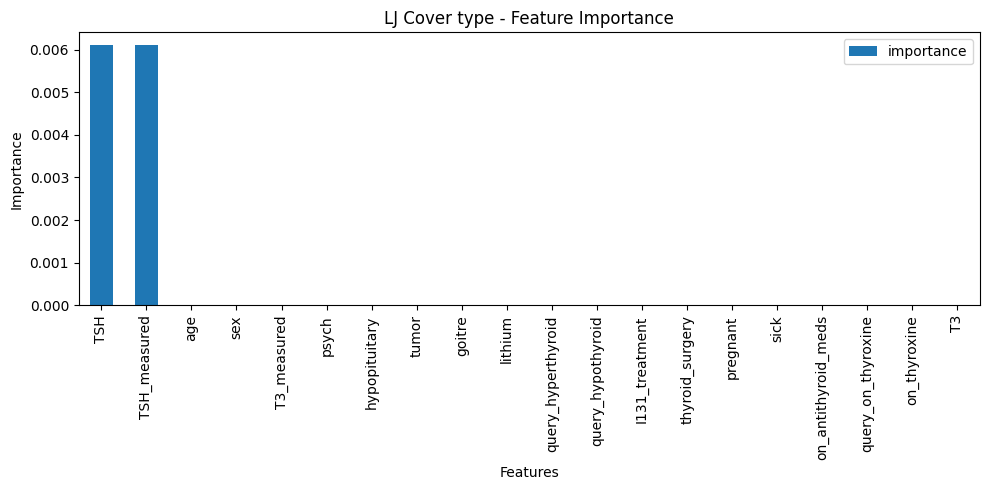

-----------------------------------------------------------------------------------------------




A importance list:
A 
                      importance
Features                       
T3                     0.067961
age                    0.006758
TSH                    0.002776
tumor                  0.002245
TSH_measured           0.001628
psych                  0.001301
query_hyperthyroid     0.000885
sex                    0.000294
T3_measured            0.000278
query_on_thyroxine     0.000277
on_thyroxine           0.000028
query_hypothyroid      0.000000
goitre                 0.000000
I131_treatment         0.000000
hypopituitary          0.000000
thyroid_surgery        0.000000
pregnant               0.000000
sick                   0.000000
on_antithyroid_meds    0.000000
lithium                0.000000 



A=["T3","age","TSH","tumor","TSH_measured"]


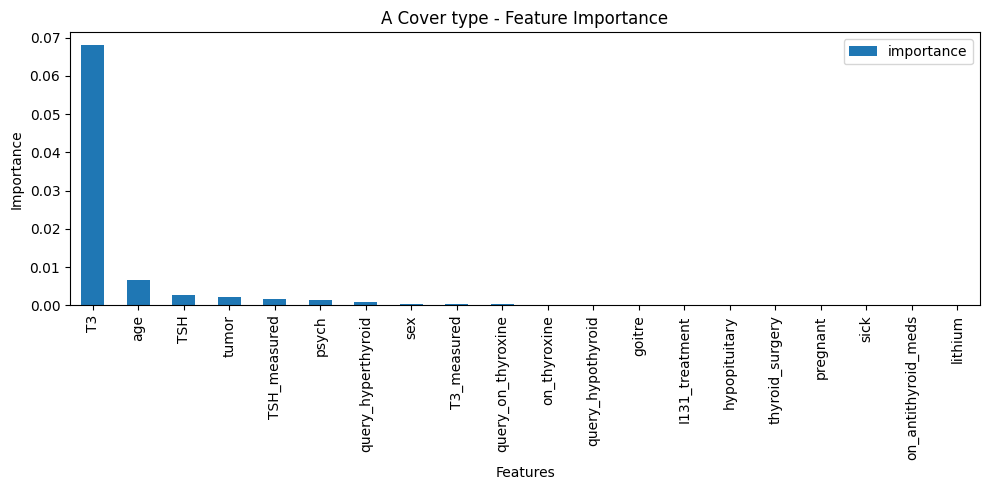

-----------------------------------------------------------------------------------------------




C importance list:
C 
                      importance
Features                       
tumor                     0.788
T3                        0.208
sex                       0.000
T3_measured               0.000
TSH                       0.000
TSH_measured              0.000
psych                     0.000
hypopituitary             0.000
goitre                    0.000
lithium                   0.000
age                       0.000
query_hypothyroid         0.000
I131_treatment            0.000
thyroid_surgery           0.000
pregnant                  0.000
sick                      0.000
on_antithyroid_meds       0.000
query_on_thyroxine        0.000
on_thyroxine              0.000
query_hyperthyroid        0.000 



C=["tumor","T3","sex","T3_measured","TSH"]


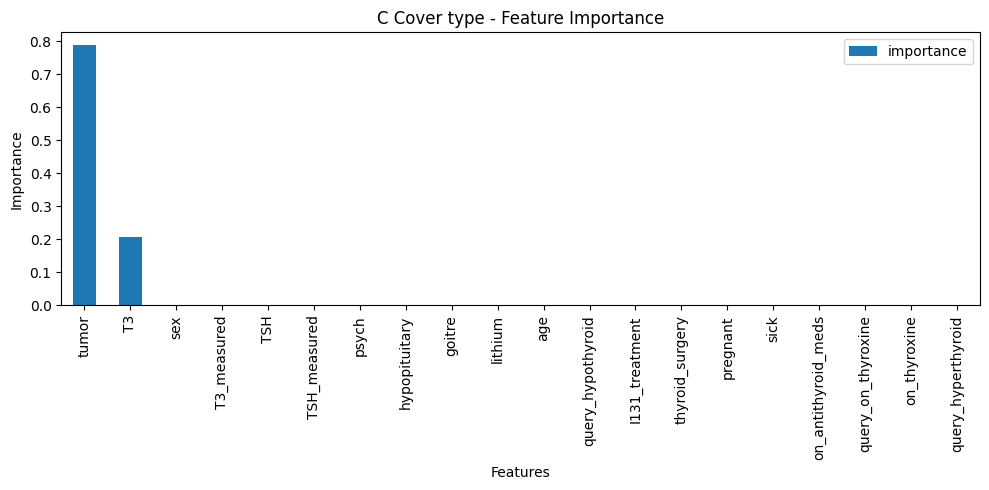

-----------------------------------------------------------------------------------------------




B importance list:
B 
                      importance
Features                       
T3                     0.962960
age                    0.013162
on_antithyroid_meds    0.011704
query_hypothyroid      0.003908
TSH                    0.000530
query_hyperthyroid     0.000258
goitre                 0.000000
T3_measured            0.000000
TSH_measured           0.000000
psych                  0.000000
hypopituitary          0.000000
tumor                  0.000000
on_thyroxine           0.000000
query_on_thyroxine     0.000000
sex                    0.000000
I131_treatment         0.000000
thyroid_surgery        0.000000
pregnant               0.000000
sick                   0.000000
lithium                0.000000 



B=["T3","age","on_antithyroid_meds","query_hypothyroid","TSH"]


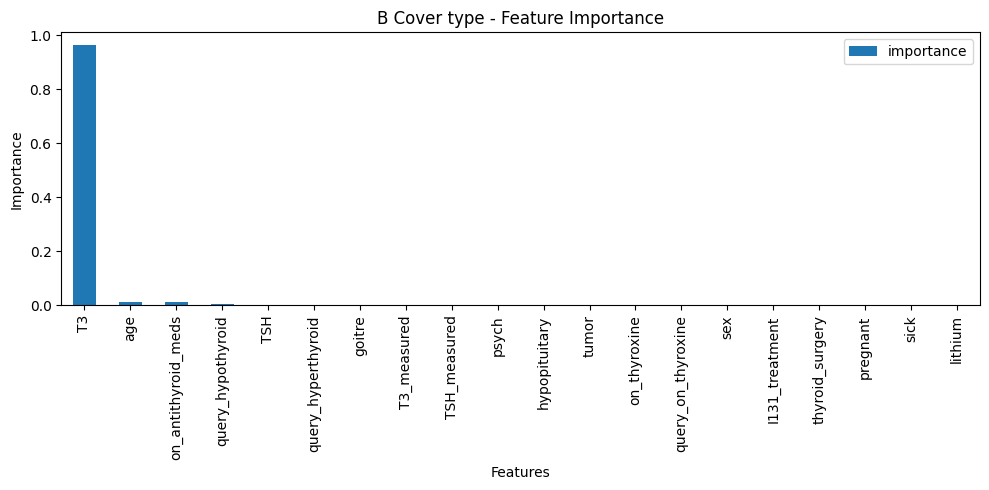

-----------------------------------------------------------------------------------------------




C|I importance list:
C|I 
                      importance
Features                       
T3                        0.832
tumor                     0.152
sex                       0.000
T3_measured               0.000
TSH                       0.000
TSH_measured              0.000
psych                     0.000
hypopituitary             0.000
goitre                    0.000
lithium                   0.000
age                       0.000
query_hypothyroid         0.000
I131_treatment            0.000
thyroid_surgery           0.000
pregnant                  0.000
sick                      0.000
on_antithyroid_meds       0.000
query_on_thyroxine        0.000
on_thyroxine              0.000
query_hyperthyroid        0.000 



C|I=["T3","tumor","sex","T3_measured","TSH"]


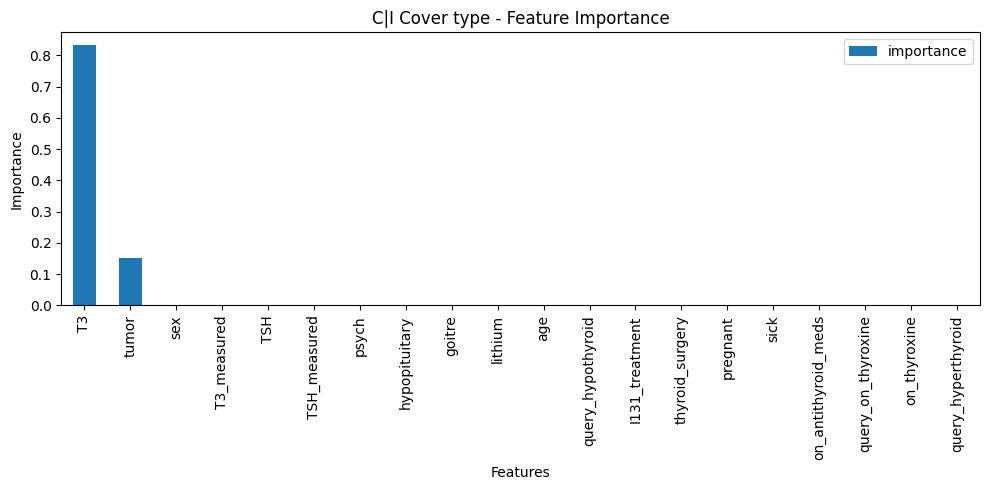

-----------------------------------------------------------------------------------------------




Q importance list:
Q 
                      importance
Features                       
thyroid_surgery        0.522438
TSH                    0.375082
T3                     0.019750
query_hyperthyroid     0.004995
I131_treatment         0.003312
T3_measured            0.002104
age                    0.001429
TSH_measured           0.000990
on_antithyroid_meds    0.000000
sick                   0.000000
pregnant               0.000000
query_on_thyroxine     0.000000
query_hypothyroid      0.000000
sex                    0.000000
lithium                0.000000
goitre                 0.000000
tumor                  0.000000
hypopituitary          0.000000
psych                  0.000000
on_thyroxine           0.000000 



Q=["thyroid_surgery","TSH","T3","query_hyperthyroid","I131_treatment"]


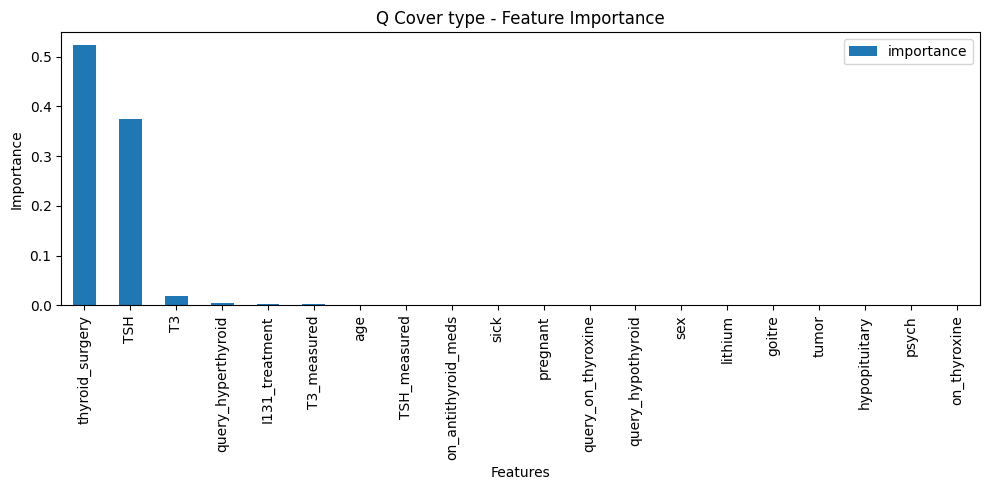

-----------------------------------------------------------------------------------------------




AK importance list:
AK 
                      importance
Features                       
TSH                    0.020306
age                    0.001203
T3_measured            0.001089
T3                     0.000683
on_thyroxine           0.000535
on_antithyroid_meds    0.000455
query_hypothyroid      0.000422
I131_treatment         0.000135
sick                   0.000000
pregnant               0.000000
thyroid_surgery        0.000000
sex                    0.000000
lithium                0.000000
goitre                 0.000000
tumor                  0.000000
hypopituitary          0.000000
psych                  0.000000
TSH_measured           0.000000
query_on_thyroxine     0.000000
query_hyperthyroid     0.000000 



AK=["TSH","age","T3_measured","T3","on_thyroxine"]


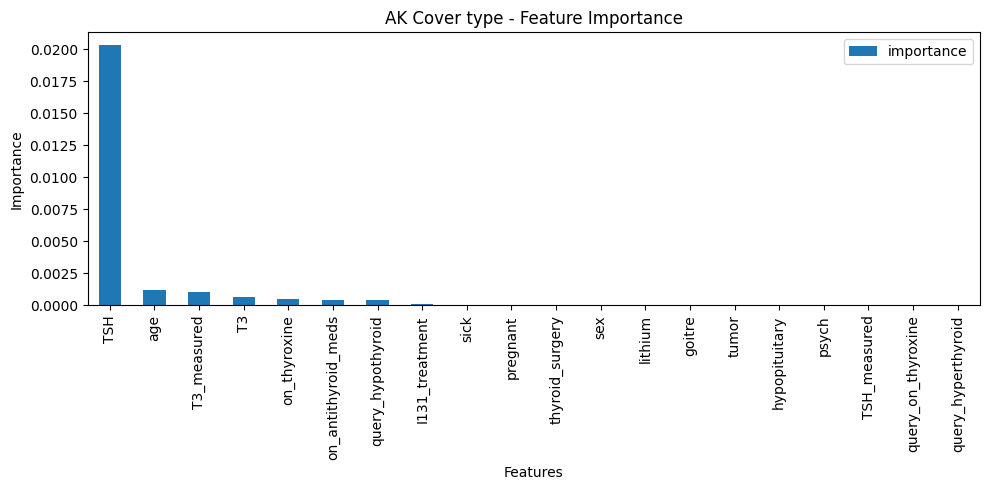

-----------------------------------------------------------------------------------------------




F importance list:
F 
                      importance
Features                       
TSH                    0.989036
T3_measured            0.000281
T3                     0.000167
age                    0.000116
sex                    0.000069
thyroid_surgery        0.000050
query_hypothyroid      0.000026
on_antithyroid_meds    0.000000
sick                   0.000000
pregnant               0.000000
I131_treatment         0.000000
lithium                0.000000
goitre                 0.000000
tumor                  0.000000
hypopituitary          0.000000
psych                  0.000000
TSH_measured           0.000000
query_on_thyroxine     0.000000
on_thyroxine           0.000000
query_hyperthyroid     0.000000 



F=["TSH","T3_measured","T3","age","sex"]


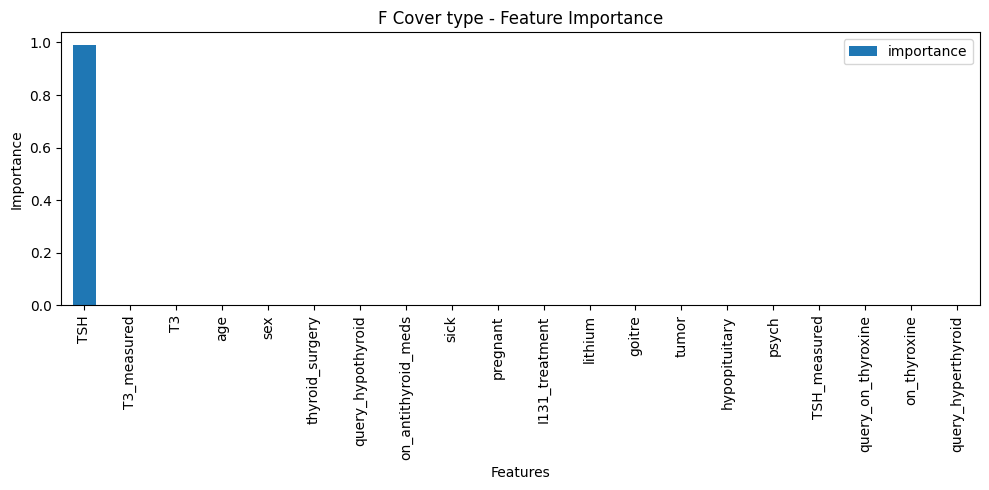

-----------------------------------------------------------------------------------------------




G importance list:
G 
                      importance
Features                       
TSH                    0.978673
T3                     0.005156
thyroid_surgery        0.004116
goitre                 0.000350
age                    0.000018
sick                   0.000000
pregnant               0.000000
on_antithyroid_meds    0.000000
I131_treatment         0.000000
query_hypothyroid      0.000000
sex                    0.000000
lithium                0.000000
query_on_thyroxine     0.000000
tumor                  0.000000
hypopituitary          0.000000
psych                  0.000000
TSH_measured           0.000000
on_thyroxine           0.000000
T3_measured            0.000000
query_hyperthyroid     0.000000 



G=["TSH","T3","thyroid_surgery","goitre","age"]


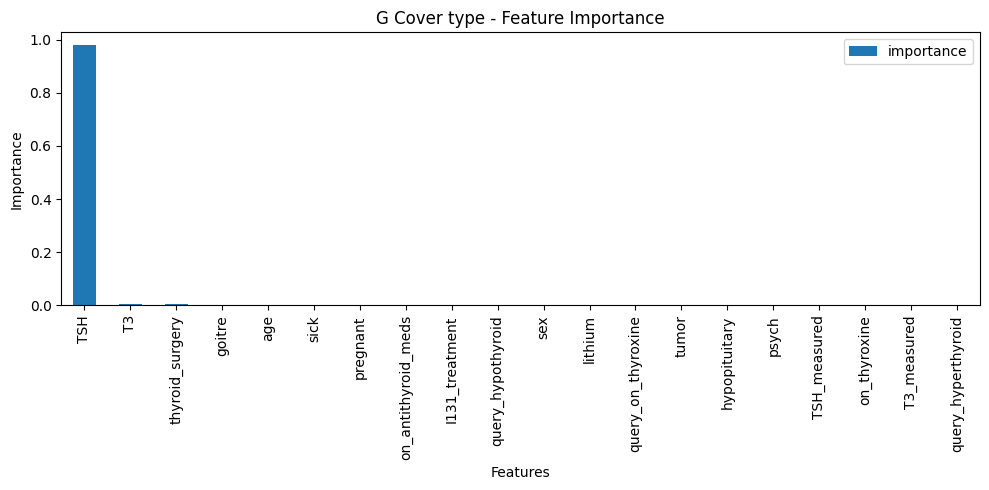

-----------------------------------------------------------------------------------------------




P importance list:
P 
                      importance
Features                       
I131_treatment         0.693548
T3                     0.048387
TSH                    0.024194
lithium                0.000000
T3_measured            0.000000
TSH_measured           0.000000
psych                  0.000000
hypopituitary          0.000000
tumor                  0.000000
goitre                 0.000000
age                    0.000000
sex                    0.000000
query_hypothyroid      0.000000
thyroid_surgery        0.000000
pregnant               0.000000
sick                   0.000000
on_antithyroid_meds    0.000000
query_on_thyroxine     0.000000
on_thyroxine           0.000000
query_hyperthyroid     0.000000 



P=["I131_treatment","T3","TSH","lithium","T3_measured"]


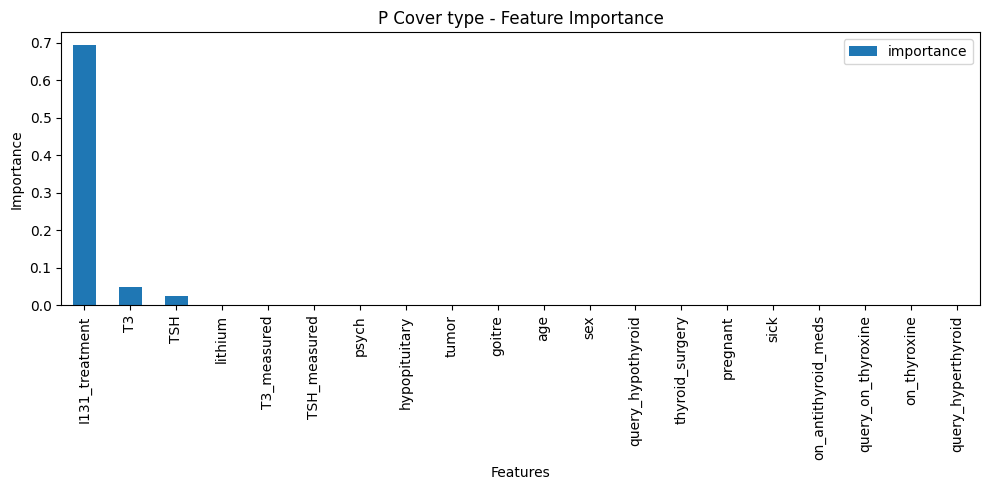

-----------------------------------------------------------------------------------------------




MI importance list:
MI 
                      importance
Features                       
TSH                    0.167421
T3                     0.117647
pregnant               0.054299
lithium                0.000000
T3_measured            0.000000
TSH_measured           0.000000
psych                  0.000000
hypopituitary          0.000000
tumor                  0.000000
goitre                 0.000000
age                    0.000000
sex                    0.000000
query_hypothyroid      0.000000
I131_treatment         0.000000
thyroid_surgery        0.000000
sick                   0.000000
on_antithyroid_meds    0.000000
query_on_thyroxine     0.000000
on_thyroxine           0.000000
query_hyperthyroid     0.000000 



MI=["TSH","T3","pregnant","lithium","T3_measured"]


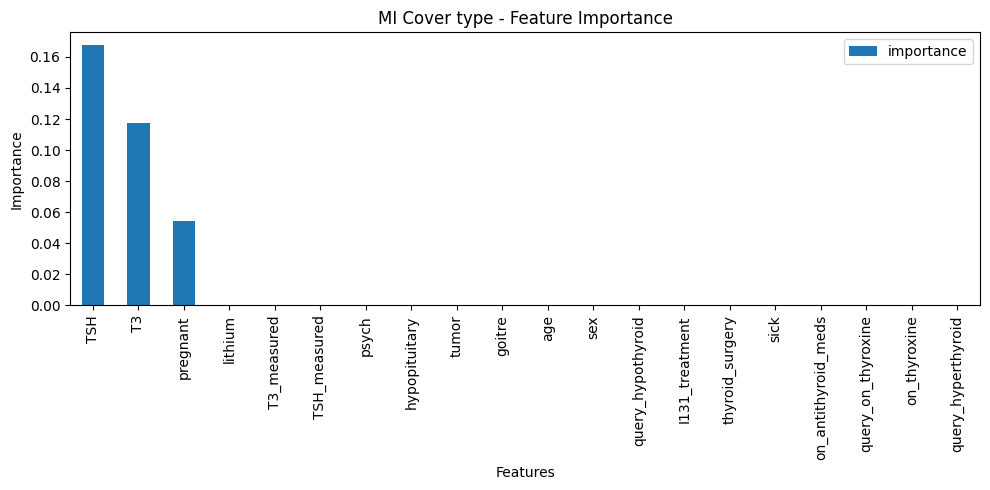

-----------------------------------------------------------------------------------------------




MK importance list:
MK 
                      importance
Features                       
T3                     0.497955
TSH                    0.483400
on_thyroxine           0.005659
T3_measured            0.003368
sex                    0.000230
lithium                0.000000
TSH_measured           0.000000
psych                  0.000000
hypopituitary          0.000000
tumor                  0.000000
goitre                 0.000000
age                    0.000000
query_hypothyroid      0.000000
I131_treatment         0.000000
thyroid_surgery        0.000000
pregnant               0.000000
sick                   0.000000
on_antithyroid_meds    0.000000
query_on_thyroxine     0.000000
query_hyperthyroid     0.000000 



MK=["T3","TSH","on_thyroxine","T3_measured","sex"]


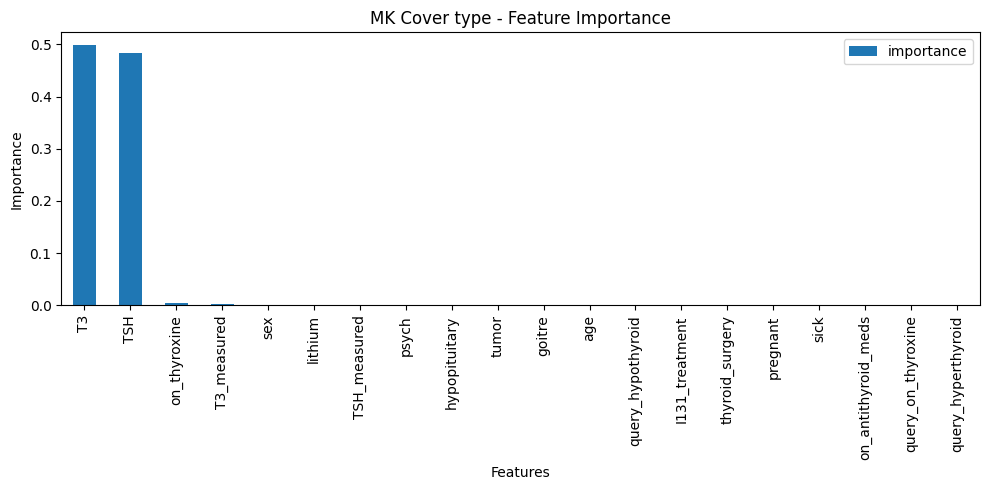

-----------------------------------------------------------------------------------------------




R importance list:
R 
                      importance
Features                       
T3                     0.064461
on_thyroxine           0.011299
sex                    0.008688
T3_measured            0.005433
age                    0.005156
TSH                    0.004091
query_hypothyroid      0.001697
psych                  0.001181
query_hyperthyroid     0.000981
TSH_measured           0.000559
on_antithyroid_meds    0.000442
thyroid_surgery        0.000023
sick                   0.000000
pregnant               0.000000
I131_treatment         0.000000
lithium                0.000000
goitre                 0.000000
tumor                  0.000000
hypopituitary          0.000000
query_on_thyroxine     0.000000 



R=["T3","on_thyroxine","sex","T3_measured","age"]


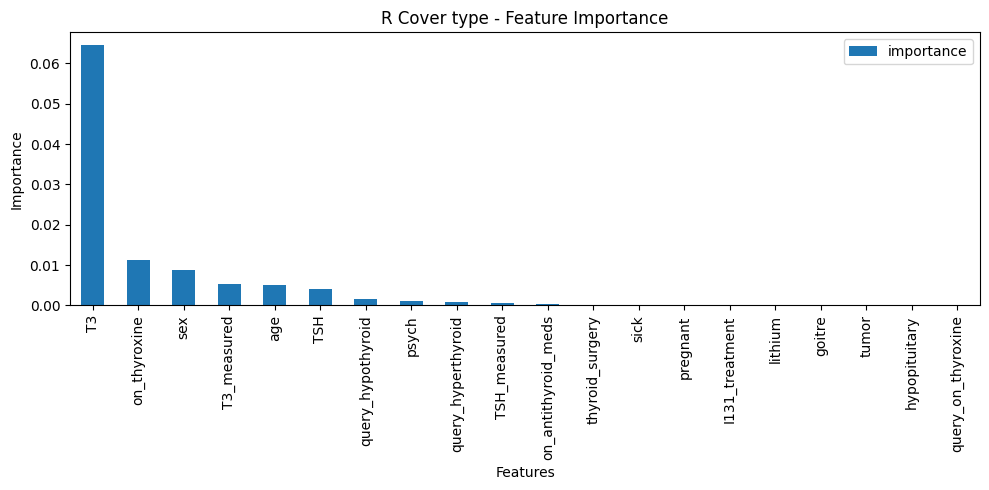

-----------------------------------------------------------------------------------------------




E importance list:
E 
                      importance
Features                       
T3                     0.134615
query_hypothyroid      0.006410
lithium                0.000000
T3_measured            0.000000
TSH                    0.000000
TSH_measured           0.000000
psych                  0.000000
hypopituitary          0.000000
tumor                  0.000000
goitre                 0.000000
age                    0.000000
sex                    0.000000
I131_treatment         0.000000
thyroid_surgery        0.000000
pregnant               0.000000
sick                   0.000000
on_antithyroid_meds    0.000000
query_on_thyroxine     0.000000
on_thyroxine           0.000000
query_hyperthyroid     0.000000 



E=["T3","query_hypothyroid","lithium","T3_measured","TSH"]


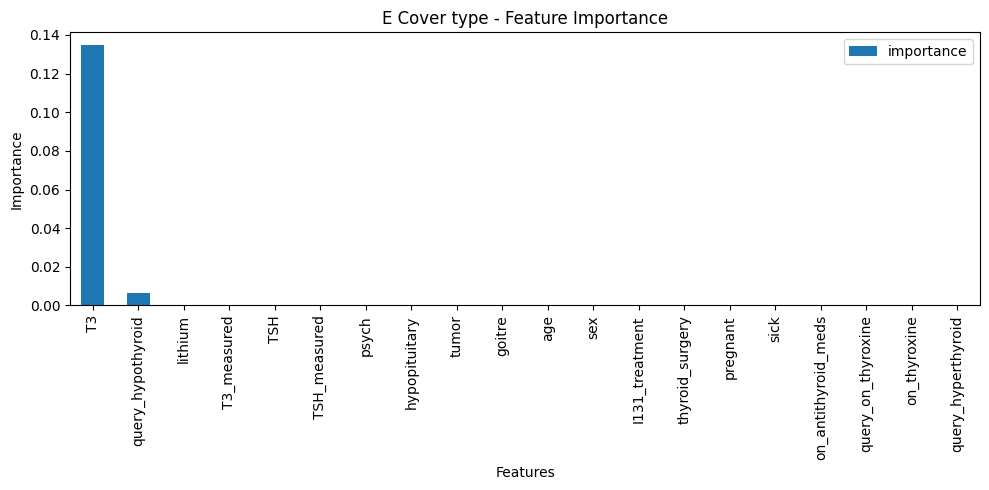

-----------------------------------------------------------------------------------------------




D importance list:
D 
                      importance
Features                       
TSH                       0.332
T3                        0.320
sex                       0.000
T3_measured               0.000
TSH_measured              0.000
psych                     0.000
hypopituitary             0.000
tumor                     0.000
goitre                    0.000
lithium                   0.000
age                       0.000
query_hypothyroid         0.000
I131_treatment            0.000
thyroid_surgery           0.000
pregnant                  0.000
sick                      0.000
on_antithyroid_meds       0.000
query_on_thyroxine        0.000
on_thyroxine              0.000
query_hyperthyroid        0.000 



D=["TSH","T3","sex","T3_measured","TSH_measured"]


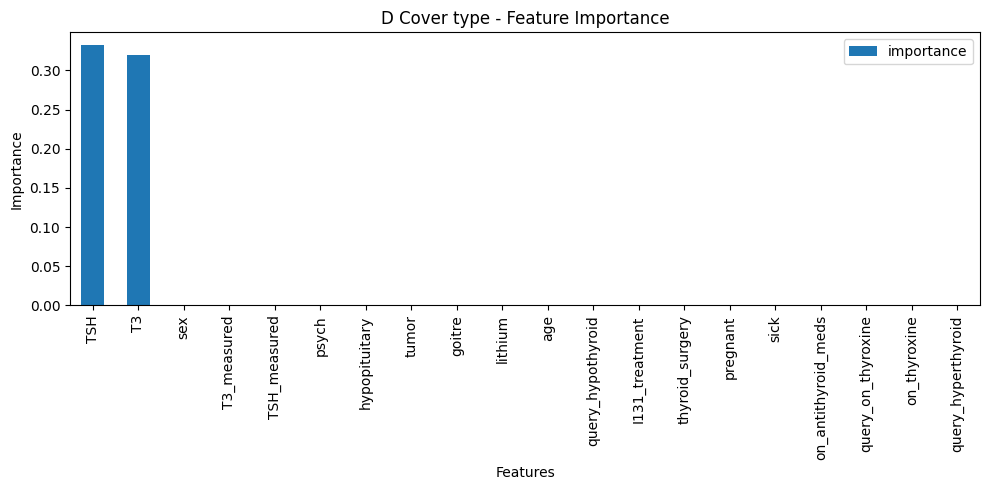

-----------------------------------------------------------------------------------------------




S importance list:
S 
                      importance
Features                       
age                         0.0
sex                         0.0
T3_measured                 0.0
TSH                         0.0
TSH_measured                0.0
psych                       0.0
hypopituitary               0.0
tumor                       0.0
goitre                      0.0
lithium                     0.0
query_hyperthyroid          0.0
query_hypothyroid           0.0
I131_treatment              0.0
thyroid_surgery             0.0
pregnant                    0.0
sick                        0.0
on_antithyroid_meds         0.0
query_on_thyroxine          0.0
on_thyroxine                0.0
T3                          0.0 



S=["age","sex","T3_measured","TSH","TSH_measured"]


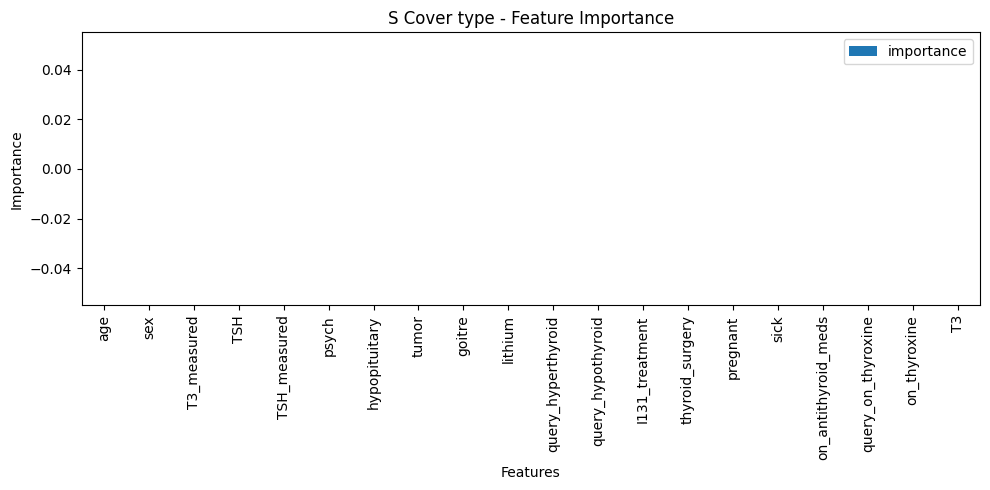

-----------------------------------------------------------------------------------------------




FK importance list:
FK 
                      importance
Features                       
T3                     0.317269
TSH                    0.028112
sex                    0.000000
T3_measured            0.000000
TSH_measured           0.000000
psych                  0.000000
hypopituitary          0.000000
tumor                  0.000000
goitre                 0.000000
lithium                0.000000
age                    0.000000
query_hypothyroid      0.000000
I131_treatment         0.000000
thyroid_surgery        0.000000
pregnant               0.000000
sick                   0.000000
on_antithyroid_meds    0.000000
query_on_thyroxine     0.000000
on_thyroxine           0.000000
query_hyperthyroid     0.000000 



FK=["T3","TSH","sex","T3_measured","TSH_measured"]


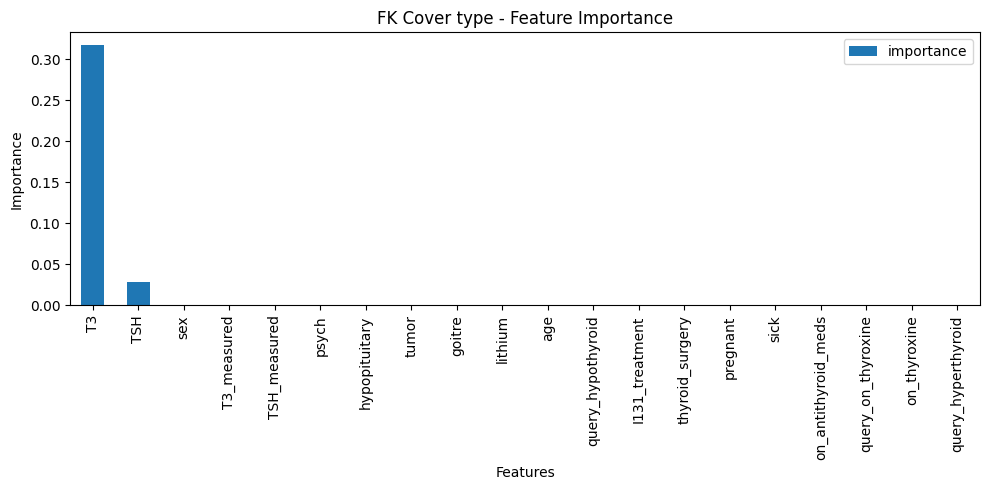

-----------------------------------------------------------------------------------------------




GI importance list:
GI 
                      importance
Features                       
T3                        0.484
TSH                       0.456
sex                       0.000
T3_measured               0.000
TSH_measured              0.000
psych                     0.000
hypopituitary             0.000
tumor                     0.000
goitre                    0.000
lithium                   0.000
age                       0.000
query_hypothyroid         0.000
I131_treatment            0.000
thyroid_surgery           0.000
pregnant                  0.000
sick                      0.000
on_antithyroid_meds       0.000
query_on_thyroxine        0.000
on_thyroxine              0.000
query_hyperthyroid        0.000 



GI=["T3","TSH","sex","T3_measured","TSH_measured"]


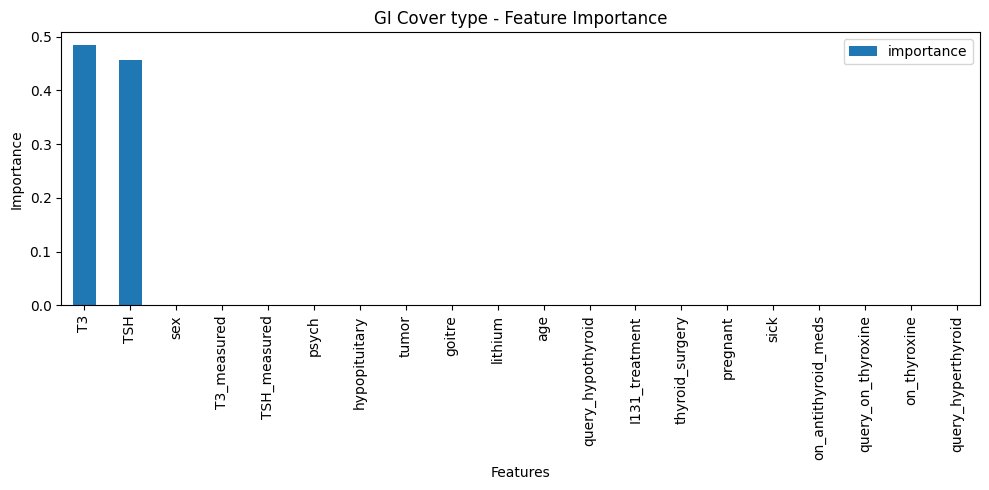

-----------------------------------------------------------------------------------------------




KJ importance list:
KJ 
                      importance
Features                       
T3                        0.108
sex                       0.000
T3_measured               0.000
TSH                       0.000
TSH_measured              0.000
psych                     0.000
hypopituitary             0.000
tumor                     0.000
goitre                    0.000
lithium                   0.000
age                       0.000
query_hypothyroid         0.000
I131_treatment            0.000
thyroid_surgery           0.000
pregnant                  0.000
sick                      0.000
on_antithyroid_meds       0.000
query_on_thyroxine        0.000
on_thyroxine              0.000
query_hyperthyroid        0.000 



KJ=["T3","sex","T3_measured","TSH","TSH_measured"]


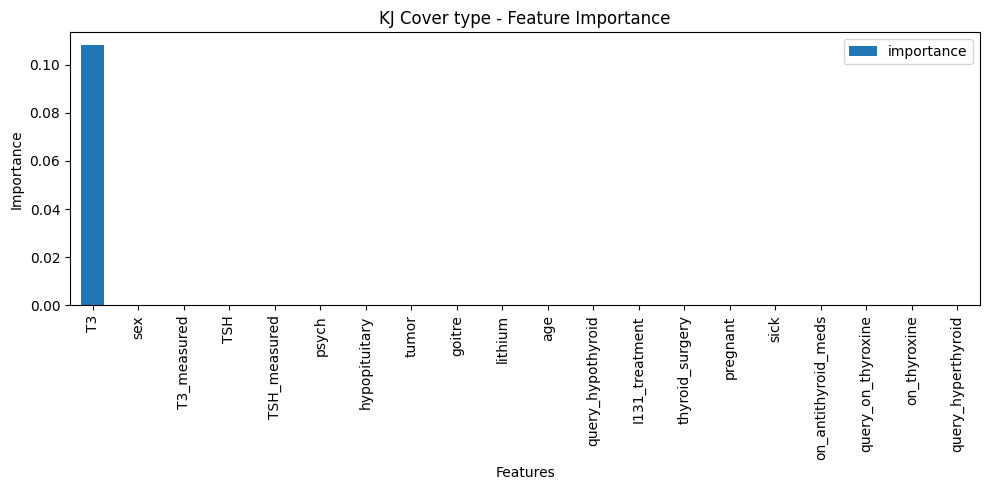

-----------------------------------------------------------------------------------------------




GK importance list:
GK 
                      importance
Features                       
TSH                    0.712370
T3                     0.273452
on_thyroxine           0.001876
lithium                0.000000
T3_measured            0.000000
TSH_measured           0.000000
psych                  0.000000
hypopituitary          0.000000
tumor                  0.000000
goitre                 0.000000
age                    0.000000
sex                    0.000000
query_hypothyroid      0.000000
I131_treatment         0.000000
thyroid_surgery        0.000000
pregnant               0.000000
sick                   0.000000
on_antithyroid_meds    0.000000
query_on_thyroxine     0.000000
query_hyperthyroid     0.000000 



GK=["TSH","T3","on_thyroxine","lithium","T3_measured"]


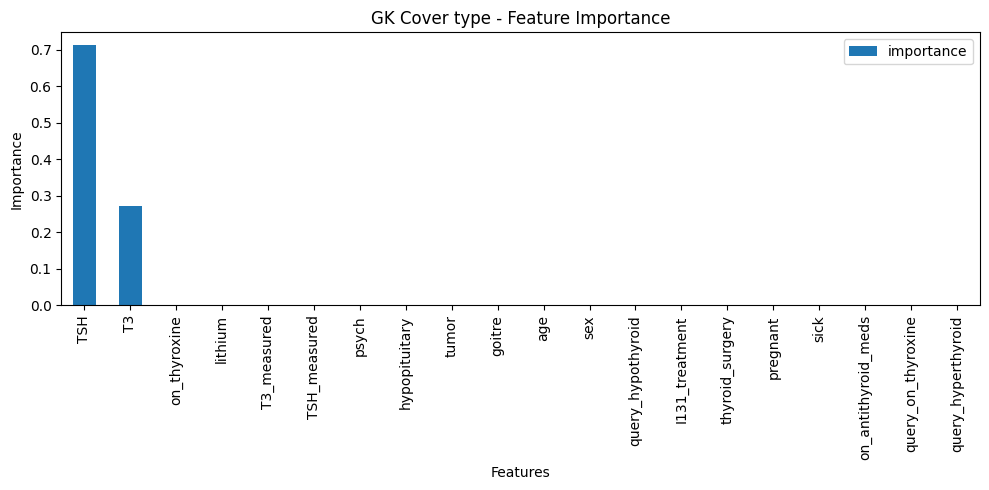

-----------------------------------------------------------------------------------------------




H|K importance list:
H|K 
                      importance
Features                       
TSH                    0.020229
T3                     0.011479
age                    0.009447
sex                    0.001566
query_on_thyroxine     0.000000
goitre                 0.000000
T3_measured            0.000000
on_thyroxine           0.000000
TSH_measured           0.000000
psych                  0.000000
hypopituitary          0.000000
tumor                  0.000000
lithium                0.000000
on_antithyroid_meds    0.000000
query_hypothyroid      0.000000
I131_treatment         0.000000
thyroid_surgery        0.000000
pregnant               0.000000
sick                   0.000000
query_hyperthyroid     0.000000 



H|K=["TSH","T3","age","sex","query_on_thyroxine"]


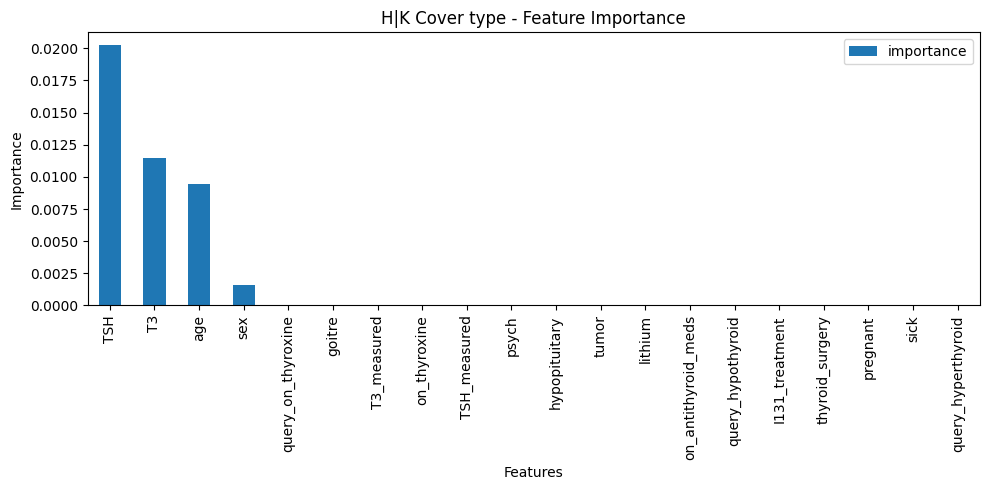

-----------------------------------------------------------------------------------------------




D|R importance list:
D|R 
                      importance
Features                       
TSH                    0.383648
query_hypothyroid      0.094340
age                    0.000000
lithium                0.000000
T3_measured            0.000000
TSH_measured           0.000000
psych                  0.000000
hypopituitary          0.000000
tumor                  0.000000
goitre                 0.000000
query_hyperthyroid     0.000000
sex                    0.000000
I131_treatment         0.000000
thyroid_surgery        0.000000
pregnant               0.000000
sick                   0.000000
on_antithyroid_meds    0.000000
query_on_thyroxine     0.000000
on_thyroxine           0.000000
T3                     0.000000 



D|R=["TSH","query_hypothyroid","age","lithium","T3_measured"]


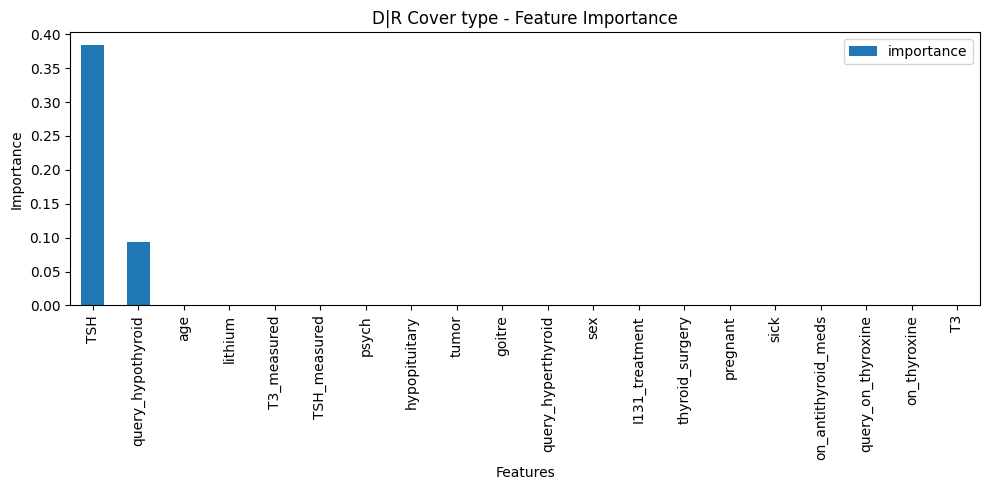

-----------------------------------------------------------------------------------------------




I importance list:
I 
                      importance
Features                       
T3                     0.189358
age                    0.022736
sex                    0.012465
TSH                    0.012256
psych                  0.007511
thyroid_surgery        0.005828
on_thyroxine           0.004331
sick                   0.003552
T3_measured            0.002501
query_hypothyroid      0.000972
lithium                0.000795
pregnant               0.000527
TSH_measured           0.000240
query_hyperthyroid     0.000206
I131_treatment         0.000114
tumor                  0.000052
on_antithyroid_meds    0.000016
goitre                 0.000009
query_on_thyroxine     0.000000
hypopituitary          0.000000 



I=["T3","age","sex","TSH","psych"]


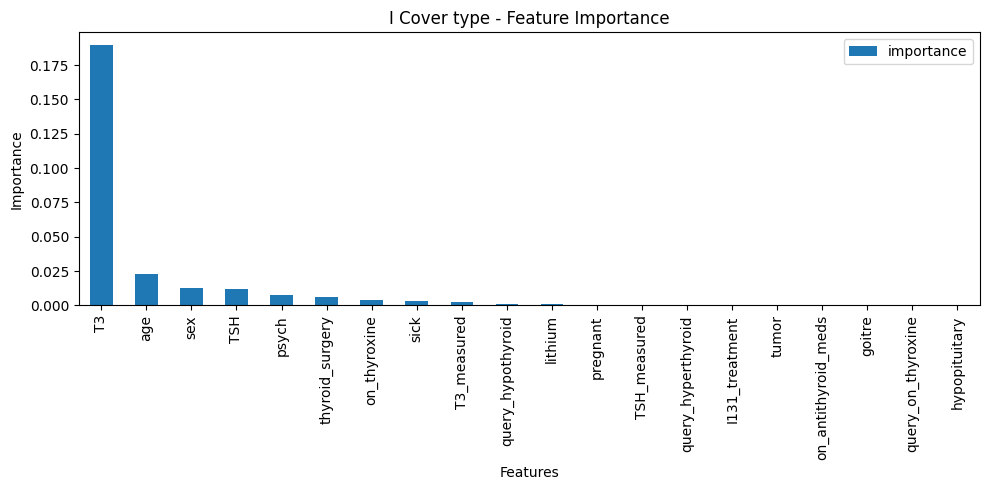

-----------------------------------------------------------------------------------------------




J importance list:
J 
                      importance
Features                       
TSH                    0.002042
TSH_measured           0.001455
age                    0.001113
sex                    0.000000
T3_measured            0.000000
psych                  0.000000
hypopituitary          0.000000
tumor                  0.000000
goitre                 0.000000
lithium                0.000000
query_hyperthyroid     0.000000
query_hypothyroid      0.000000
I131_treatment         0.000000
thyroid_surgery        0.000000
pregnant               0.000000
sick                   0.000000
on_antithyroid_meds    0.000000
query_on_thyroxine     0.000000
on_thyroxine           0.000000
T3                     0.000000 



J=["TSH","TSH_measured","age","sex","T3_measured"]


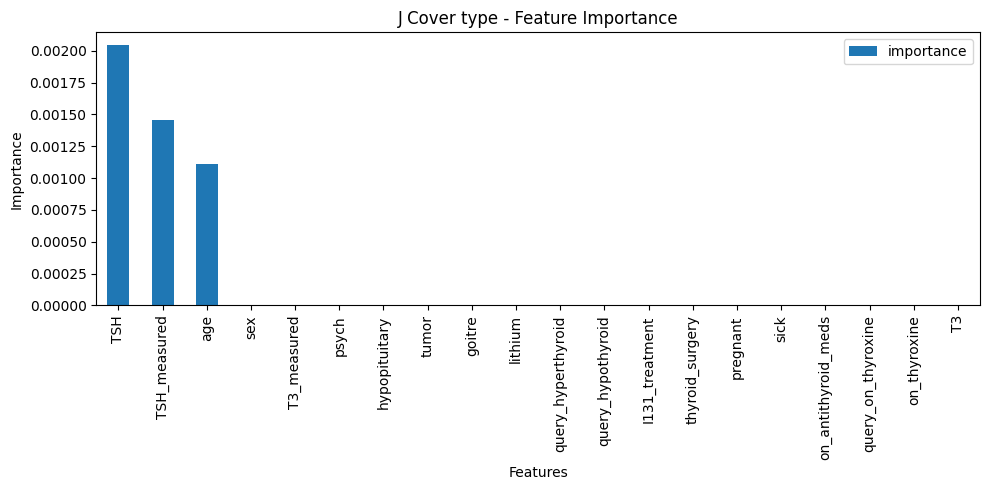

-----------------------------------------------------------------------------------------------




K importance list:
K 
                      importance
Features                       
T3                     0.882969
age                    0.011707
TSH                    0.004367
on_thyroxine           0.001955
psych                  0.001597
query_on_thyroxine     0.001284
sex                    0.000364
query_hyperthyroid     0.000363
sick                   0.000331
query_hypothyroid      0.000291
lithium                0.000253
T3_measured            0.000219
thyroid_surgery        0.000108
on_antithyroid_meds    0.000105
hypopituitary          0.000099
tumor                  0.000039
I131_treatment         0.000000
pregnant               0.000000
goitre                 0.000000
TSH_measured           0.000000 



K=["T3","age","TSH","on_thyroxine","psych"]


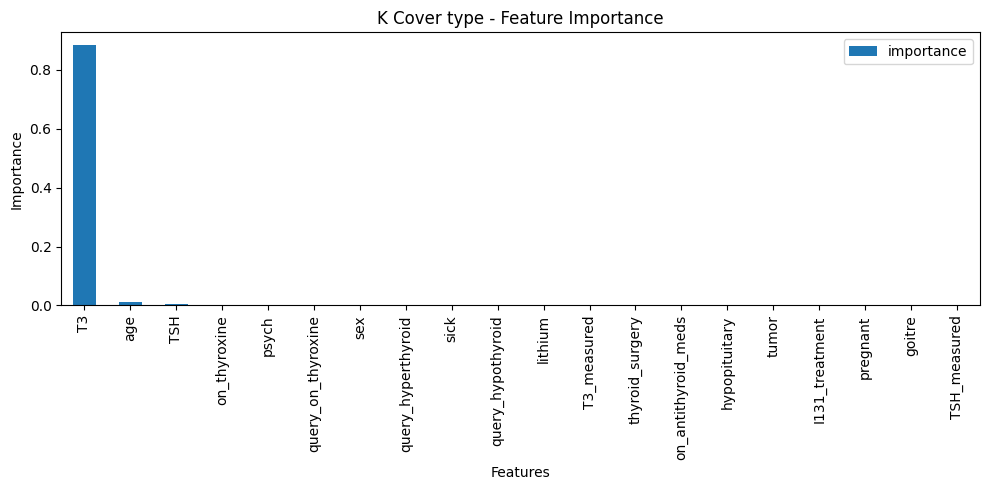

-----------------------------------------------------------------------------------------------




OI importance list:
OI 
                      importance
Features                       
TSH                    0.314103
on_antithyroid_meds    0.269231
T3                     0.121795
on_thyroxine           0.006410
lithium                0.000000
T3_measured            0.000000
TSH_measured           0.000000
psych                  0.000000
hypopituitary          0.000000
tumor                  0.000000
goitre                 0.000000
age                    0.000000
sex                    0.000000
query_hypothyroid      0.000000
I131_treatment         0.000000
thyroid_surgery        0.000000
pregnant               0.000000
sick                   0.000000
query_on_thyroxine     0.000000
query_hyperthyroid     0.000000 



OI=["TSH","on_antithyroid_meds","T3","on_thyroxine","lithium"]


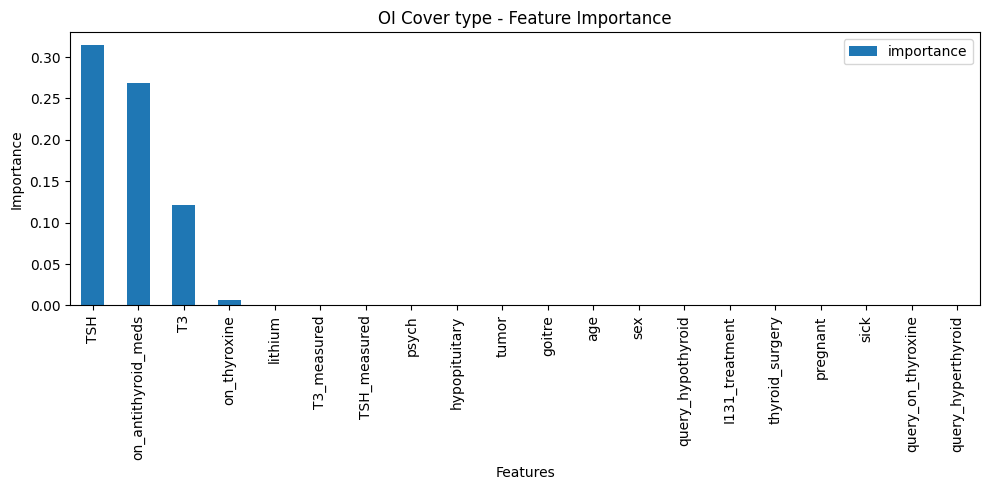

-----------------------------------------------------------------------------------------------




O importance list:
O 
                      importance
Features                       
age                         0.0
sex                         0.0
T3_measured                 0.0
TSH                         0.0
TSH_measured                0.0
psych                       0.0
hypopituitary               0.0
tumor                       0.0
goitre                      0.0
lithium                     0.0
query_hyperthyroid          0.0
query_hypothyroid           0.0
I131_treatment              0.0
thyroid_surgery             0.0
pregnant                    0.0
sick                        0.0
on_antithyroid_meds         0.0
query_on_thyroxine          0.0
on_thyroxine                0.0
T3                          0.0 



O=["age","sex","T3_measured","TSH","TSH_measured"]


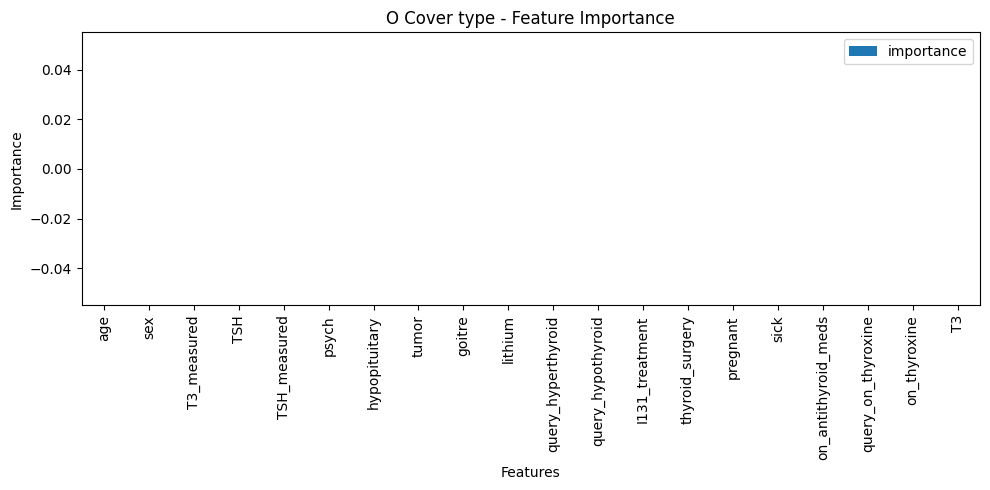

-----------------------------------------------------------------------------------------------




N importance list:
N 
                      importance
Features                       
on_thyroxine           0.009119
T3                     0.008417
TSH                    0.002397
age                    0.002078
query_hyperthyroid     0.001523
T3_measured            0.000461
TSH_measured           0.000455
sex                    0.000439
on_antithyroid_meds    0.000000
sick                   0.000000
pregnant               0.000000
thyroid_surgery        0.000000
I131_treatment         0.000000
query_hypothyroid      0.000000
lithium                0.000000
goitre                 0.000000
tumor                  0.000000
hypopituitary          0.000000
psych                  0.000000
query_on_thyroxine     0.000000 



N=["on_thyroxine","T3","TSH","age","query_hyperthyroid"]


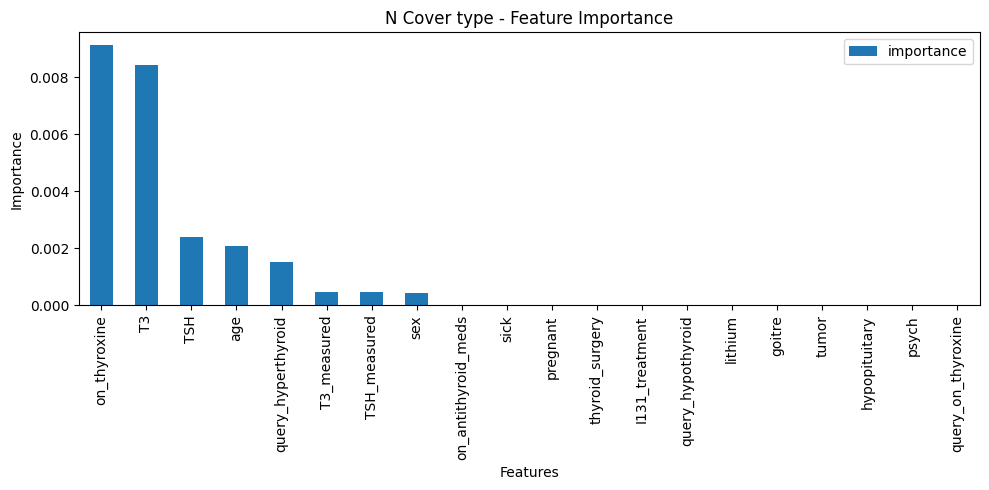

-----------------------------------------------------------------------------------------------




GKJ importance list:
GKJ 
                      importance
Features                       
TSH                    0.295455
T3                     0.221591
sex                    0.000000
T3_measured            0.000000
TSH_measured           0.000000
psych                  0.000000
hypopituitary          0.000000
tumor                  0.000000
goitre                 0.000000
lithium                0.000000
age                    0.000000
query_hypothyroid      0.000000
I131_treatment         0.000000
thyroid_surgery        0.000000
pregnant               0.000000
sick                   0.000000
on_antithyroid_meds    0.000000
query_on_thyroxine     0.000000
on_thyroxine           0.000000
query_hyperthyroid     0.000000 



GKJ=["TSH","T3","sex","T3_measured","TSH_measured"]


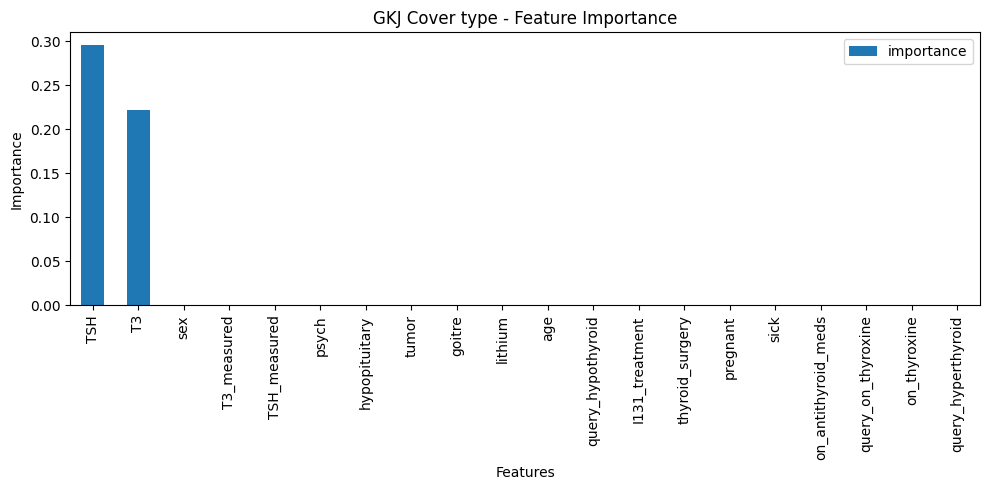

-----------------------------------------------------------------------------------------------




L importance list:
L 
                      importance
Features                       
psych                  0.016820
age                    0.006354
T3                     0.004536
TSH                    0.001855
query_on_thyroxine     0.001103
sex                    0.000604
on_thyroxine           0.000318
on_antithyroid_meds    0.000276
T3_measured            0.000254
query_hypothyroid      0.000080
TSH_measured           0.000062
tumor                  0.000000
hypopituitary          0.000000
lithium                0.000000
goitre                 0.000000
I131_treatment         0.000000
thyroid_surgery        0.000000
pregnant               0.000000
sick                   0.000000
query_hyperthyroid     0.000000 



L=["psych","age","T3","TSH","query_on_thyroxine"]


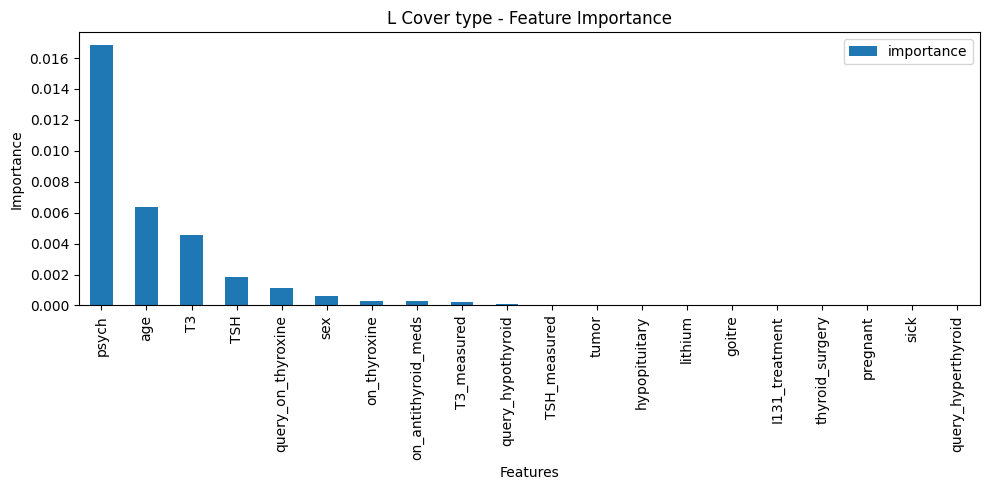

-----------------------------------------------------------------------------------------------




M importance list:
M 
                      importance
Features                       
TSH                    0.938496
on_thyroxine           0.020155
T3                     0.003589
age                    0.000758
tumor                  0.000687
sick                   0.000080
on_antithyroid_meds    0.000000
pregnant               0.000000
thyroid_surgery        0.000000
I131_treatment         0.000000
query_hypothyroid      0.000000
sex                    0.000000
lithium                0.000000
goitre                 0.000000
hypopituitary          0.000000
psych                  0.000000
TSH_measured           0.000000
query_on_thyroxine     0.000000
T3_measured            0.000000
query_hyperthyroid     0.000000 



M=["TSH","on_thyroxine","T3","age","tumor"]


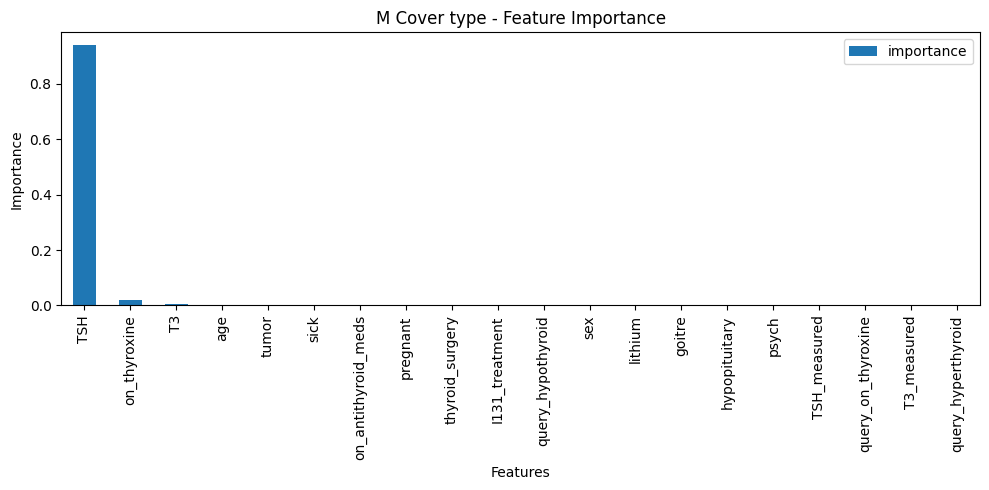

-----------------------------------------------------------------------------------------------




feature_importances: {'LJ': ['TSH', 'TSH_measured', 'age', 'sex', 'T3_measured'], 'A': ['T3', 'age', 'TSH', 'tumor', 'TSH_measured'], 'C': ['tumor', 'T3', 'sex', 'T3_measured', 'TSH'], 'B': ['T3', 'age', 'on_antithyroid_meds', 'query_hypothyroid', 'TSH'], 'C|I': ['T3', 'tumor', 'sex', 'T3_measured', 'TSH'], 'Q': ['thyroid_surgery', 'TSH', 'T3', 'query_hyperthyroid', 'I131_treatment'], 'AK': ['TSH', 'age', 'T3_measured', 'T3', 'on_thyroxine'], 'F': ['TSH', 'T3_measured', 'T3', 'age', 'sex'], 'G': ['TSH', 'T3', 'thyroid_surgery', 'goitre', 'age'], 'P': ['I131_treatment', 'T3', 'TSH', 'lithium', 'T3_measured'], 'MI': ['TSH', 'T3', 'pregnant', 'lithium', 'T3_measured'], 'MK': ['T3', 'TSH', 'on_thyroxine', 'T3_measured', 'sex'], 'R': ['T3', 'on_thyroxine', 'sex', 'T3_measured', 'age'], 'E': ['T3', 'query_hypothyroid', 'lithium', 'T3_measured', 'TSH'], 'D': ['TSH', 'T3', 'sex', 'T3_measured', 

In [25]:
seconds = time.time()

# CSV files names:
csv_files=os.listdir(OUTPUT_FOLDER)
print('csv_files',csv_files)

feature_importances = {}
SVMs = {}

process_csv_with_args = partial(
        common.process_csv, 
        main_labels=main_labels, 
        target_column=TARGET_COLUMN, 
        normal_target=NORMAL_TARGET, 
        numerical_columns=NUMERICAL_COLUMNS, 
        output_folder=OUTPUT_FOLDER,
        scaler=scaler 
    )

with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_csv_with_args, csv_files))

# Collect results from the futures
for label, important_features, svm, impor_bars in results:
    feature_importances[label] = important_features
    SVMs[label] = svm

    # Show feature importance
    common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances:', feature_importances)
print("Total operation time: =", time.time() - seconds, "seconds")

In [27]:
seconds = time.time()

# Step 1: Train KNN to classify
knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train_scaled_df, y_train_df)
knn.fit(X_train_df, y_train_df)

# Step 2: Predict classes for the test set
X_test_df = X_test_df[:TEST_COUNT]
X_test_scaled_df = X_test_scaled_df[:TEST_COUNT]
y_test_df = y_test_df[:TEST_COUNT]

# knn_predictions = knn.predict(X_test_scaled)
knn_predictions = knn.predict(X_test_df)
print('knn_predictions', knn_predictions)

print("Total operation time: = ",time.time()- seconds ,"seconds")

knn_predictions [25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 10 25  0 25  8 24 25
 31 15 25 25 25 25 25 25  0 25 25 25 25 25 19 25 15 25 25 25 25 25 25 25
 10 25 25 25 25 25 25 25 25 25 25 24 25 15 25 25 25 25 25 25 15 15 25 25
 25 31 25 17 25 25 25 25 25 25 25 25 25 19 25 25 25 25 25 30 25 25 25 25
 25 25 25 25 25 25 25 24 25 25 25 17 25 25 25 25 10 17 25 25 25 25 25 25
 25 25 25 25 25 15 25 25 25 17 25 25 25 15 25 15 25 25 25 25 25 25 25 25
 25 15 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 31 10 25 25
 25 25 25 25 25 25 25 25 25 25 25  0 25 25 25 26 25 25 25 25 10 25 25 25
 25 25 25 25 10 25 25 25 25 25 25 25 25 10 31 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 19 17 10 25 25 15 25 25 25 25 25 25 19 25  0  8 25
  0 25 25 25 25 25 25 25  0 25 25 25 25 25  0 25 25 25 25 25 24 25 25 25
 19 25 25 25 25 25 25 25 31 25 25 25 25 25 25 25 25 25 25 25 25 25 25 17
 25 15 25 25 25 25 25 25 25 17 25 25 25 25 25 25 25 25 25 25 25 25 25 17
 25  1 25 21 25 25 25 25 25 25 25 2

-----KNN Evaluation-----
Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   1
    0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   3   0   0   0
    0]
 [  0   0   0   5   0   0   0   0   1   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   7   0   0   0   0   0   0   0   0  13   0   0   0
    0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   1   0   0   0
    0]
 [  1   0   0   0   0   0   0   8   0   0   0   0   0   1  12   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   4   0   0   0   0   0  26   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
    0]
 [  2   1   0   0   0   0   0   2   0   0   2   0   0   1   2   0   0   0
    0]
 [  0   0   0   0   0   4   0   1   0   0   0   0   0   0   0   0 

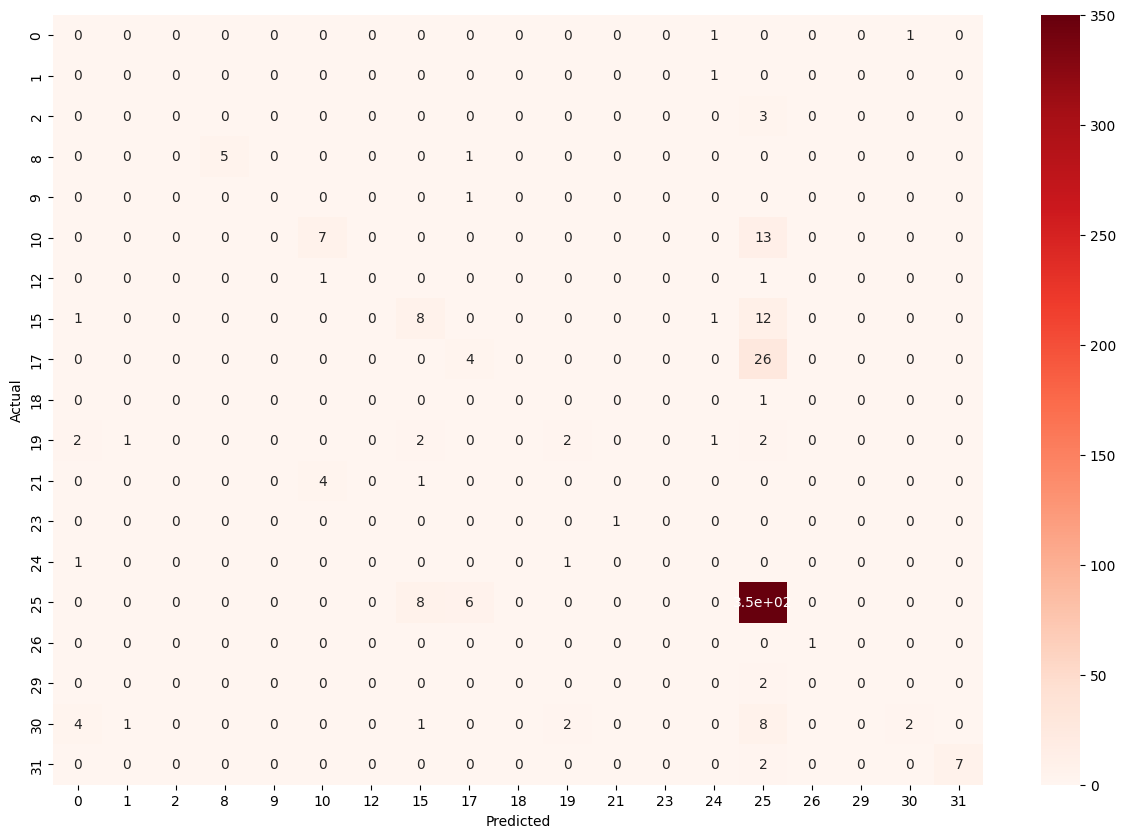


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         3
           8       1.00      0.83      0.91         6
           9       0.00      0.00      0.00         1
          10       0.58      0.35      0.44        20
          12       0.00      0.00      0.00         2
          15       0.40      0.36      0.38        22
          17       0.33      0.13      0.19        30
          18       0.00      0.00      0.00         1
          19       0.40      0.20      0.27        10
          21       0.00      0.00      0.00         5
          23       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         2
          25       0.83      0.96      0.89       364
          26       1.00      1.00      1.00         1
          29       0.00      0.00      0.00         2
   

/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [29]:
common.evaluate(y_test_df, knn_predictions, heading='-----KNN Evaluation-----')

In [30]:
svm_predictions = []
seconds = time.time()

for i in range(len(X_test_scaled_df)):
    test_instance_df = X_test_scaled_df.iloc[i].to_frame().T
    if knn_predictions[i] == NORMAL_TARGET:
        svm_predictions.append((0, NORMAL_TARGET, y_test_df.iloc[i]))
        continue
    predicted_label = TARGET_DICT[knn_predictions[i]]
    # print('predicted_label', predicted_label)
    selected_features = feature_importances[predicted_label]
    # print('selected_features', selected_features)
    svm_model = SVMs[predicted_label]
    
    # Select features for the SVM
    test_instance_selected_df = test_instance_df[selected_features]
    svm_prediction = svm_model.predict(test_instance_selected_df)
    print('svm prediction: ', svm_prediction, 'knn prediction: ', INV_TARGET_DICT[predicted_label], 'actual value: ', y_test_df.iloc[i])
    svm_predictions.append((svm_prediction, INV_TARGET_DICT[predicted_label], y_test_df.iloc[i]))

print("Total operation time: = ",time.time()- seconds ,"seconds")

svm prediction:  [1] knn prediction:  10 actual value:  10
svm prediction:  [1] knn prediction:  0 actual value:  30
svm prediction:  [1] knn prediction:  8 actual value:  8
svm prediction:  [1] knn prediction:  24 actual value:  1
svm prediction:  [0] knn prediction:  31 actual value:  31
svm prediction:  [0] knn prediction:  15 actual value:  15
svm prediction:  [1] knn prediction:  0 actual value:  15
svm prediction:  [1] knn prediction:  19 actual value:  19
svm prediction:  [0] knn prediction:  15 actual value:  25
svm prediction:  [1] knn prediction:  10 actual value:  21
svm prediction:  [1] knn prediction:  24 actual value:  0
svm prediction:  [0] knn prediction:  15 actual value:  25
svm prediction:  [0] knn prediction:  15 actual value:  25
svm prediction:  [0] knn prediction:  15 actual value:  25
svm prediction:  [0] knn prediction:  31 actual value:  31
svm prediction:  [1] knn prediction:  17 actual value:  25
svm prediction:  [1] knn prediction:  19 actual value:  30
svm

anomaly_mask 500
[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 10, 25, 0, 25, 8, 24, 25, 31, 15, 25, 25, 25, 25, 25, 25, 0, 25, 25, 25, 25, 25, 19, 25, 15, 25, 25, 25, 25, 25, 25, 25, 10, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 24, 25, 15, 25, 25, 25, 25, 25, 25, 15, 15, 25, 25, 25, 31, 25, 17, 25, 25, 25, 25, 25, 25, 25, 25, 25, 19, 25, 25, 25, 25, 25, 30, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 24, 25, 25, 25, 17, 25, 25, 25, 25, 10, 17, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 15, 25, 25, 25, 17, 25, 25, 25, 15, 25, 15, 25, 25, 25, 25, 25, 25, 25, 25, 25, 15, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 31, 10, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 0, 25, 25, 25, 26, 25, 25, 25, 25, 10, 25, 25, 25, 25, 25, 25, 25, 10, 25, 25, 25, 25, 25, 25, 25, 25, 10, 31, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 19, 17, 10, 25, 25, 15, 25, 25, 25, 25, 25, 25, 19, 25, 0, 8, 25, 0, 25, 25, 25, 25, 25, 25, 2

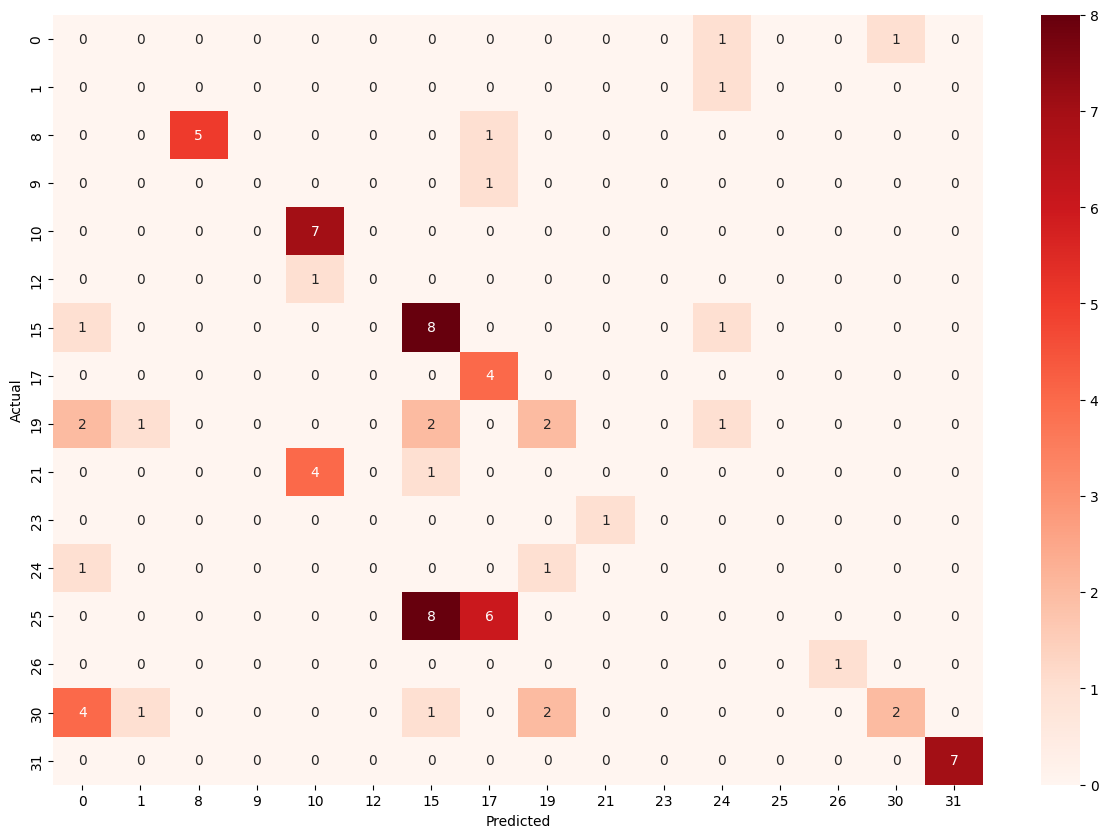


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         1
           8       1.00      0.83      0.91         6
           9       0.00      0.00      0.00         1
          10       0.58      1.00      0.74         7
          12       0.00      0.00      0.00         1
          15       0.40      0.80      0.53        10
          17       0.33      1.00      0.50         4
          19       0.40      0.25      0.31         8
          21       0.00      0.00      0.00         5
          23       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         2
          25       0.00      0.00      0.00        14
          26       1.00      1.00      1.00         1
          30       0.67      0.20      0.31        10
          31       1.00      1.00      1.00         7

    accuracy                           0.45        80
  

/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [32]:
# Now evaluate SVM predictions only for the anomalies detected by KNN
# Create a mask for test instances that KNN classified as anomalies
anomaly_mask = knn_predictions != NORMAL_TARGET  # Assuming normal_target is your normal class
print('anomaly_mask', len(anomaly_mask))

# Get true labels and predictions for anomalies
svm_predictions_actual = [t[1] for t in svm_predictions]
print(svm_predictions_actual)
# svm_predictions_actual = np.array(svm_predictions_actual)
svm_predictions_actual_df = pd.DataFrame(svm_predictions_actual, columns=[TARGET_COLUMN])
y_test_anomalies_df = y_test_df[anomaly_mask]
svm_predictions_anomalies_df = svm_predictions_actual_df[anomaly_mask]
print('Lengths: ', len(y_test_anomalies_df), len(svm_predictions_anomalies_df))

# Evaluate SVM only on the anomalies
common.evaluate(y_test_anomalies_df, svm_predictions_anomalies_df, heading='SVM Evaluation (for anomalies)')

SVM Evaluation (for all)
Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   1
    0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   3   0   0   0
    0]
 [  0   0   0   5   0   0   0   0   1   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   7   0   0   0   0   0   0   0   0  13   0   0   0
    0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   1   0   0   0
    0]
 [  1   0   0   0   0   0   0   8   0   0   0   0   0   1  12   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   4   0   0   0   0   0  26   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
    0]
 [  2   1   0   0   0   0   0   2   0   0   2   0   0   1   2   0   0   0
    0]
 [  0   0   0   0   0   4   0   1   0   0   0   0   0   0   0   0 

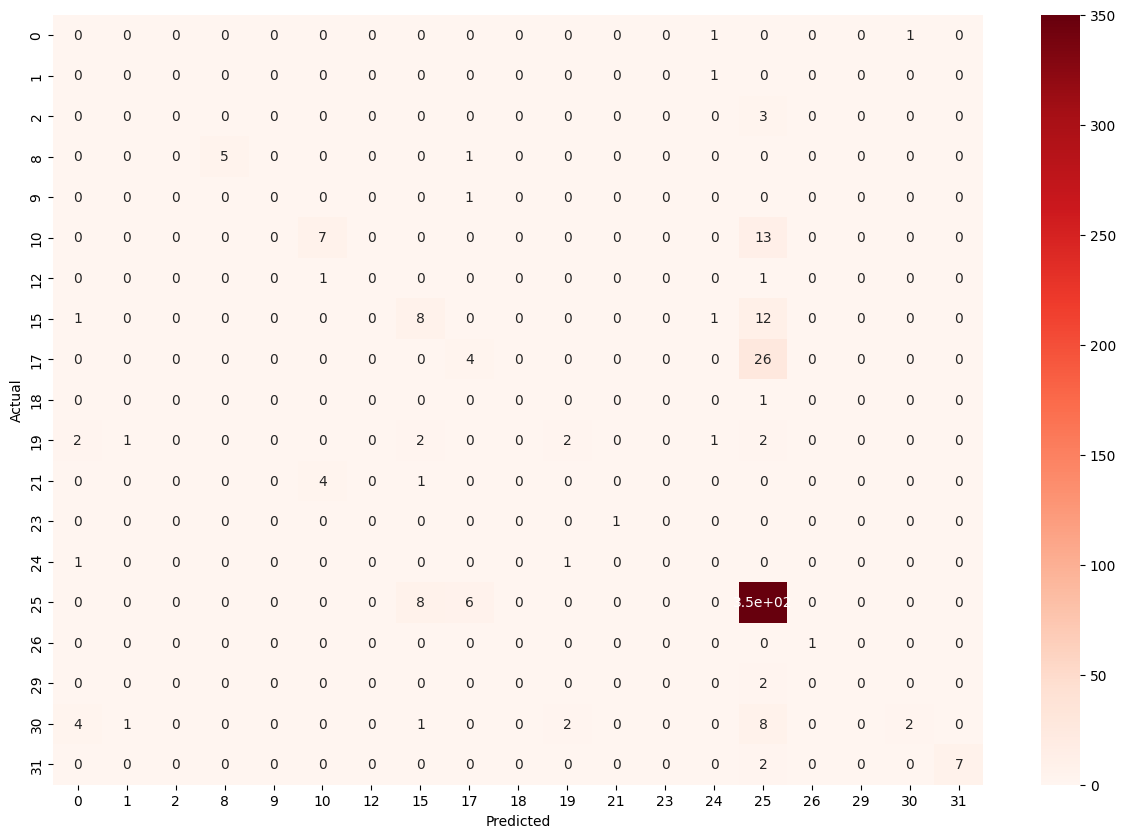


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         3
           8       1.00      0.83      0.91         6
           9       0.00      0.00      0.00         1
          10       0.58      0.35      0.44        20
          12       0.00      0.00      0.00         2
          15       0.40      0.36      0.38        22
          17       0.33      0.13      0.19        30
          18       0.00      0.00      0.00         1
          19       0.40      0.20      0.27        10
          21       0.00      0.00      0.00         5
          23       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         2
          25       0.83      0.96      0.89       364
          26       1.00      1.00      1.00         1
          29       0.00      0.00      0.00         2
   

/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [33]:
common.evaluate(y_test_df, svm_predictions_actual_df, heading='SVM Evaluation (for all)')